In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
import kagglehub
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import statsmodels.api as sm



In [ ]:
# Download dataset from Kaggle
print("Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("priyamchoksi/spotify-dataset-114k-songs")
print("Dataset downloaded to:", dataset_path)

# Find the CSV file inside the downloaded folder
csv_file = None
for file in os.listdir(dataset_path):
    if file.endswith(".csv"):
        csv_file = os.path.join(dataset_path, file)
        break

if not csv_file:
    raise FileNotFoundError("CSV file not found in the dataset folder!")

print("Loading dataset:", csv_file)

# Load data
df = pd.read_csv(csv_file).dropna()

100%|██████████| 8.17M/8.17M [00:00<00:00, 36.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/priyamchoksi/spotify-dataset-114k-songs/versions/1
Loading dataset: /root/.cache/kagglehub/datasets/priyamchoksi/spotify-dataset-114k-songs/versions/1/dataset.csv


# **EDA**

***Dataset Summary***

Popularity Distribution is Skewed

*   Mean: 33.2
*   Median: 35
*   Max: 100 suggests some very popular outliers.
*   *Potential Fix: Log-transform popularity or use quantile-based binning.*

Energy, Danceability, and Loudness Seem Important

*   These features have high variance and wide ranges, meaning they likely differentiate popular vs. non-popular songs
Speechiness, Acousticness, and Instrumentalness Have High Variance
*   Suggests that songs vary significantly in how much speech or instrumentation they have.
*   *Potential Fix: Bucket these into categorical groups (e.g., "Low", "Medium", "High" instead of raw numbers). Tempo Varies Widely (0 to 243 BPM)*

Popular songs might cluster around specific tempo ranges (e.g., 100-140 BPM is common for pop hits).

*   Potential Fix: Create tempo bins (e.g., slow, medium, fast)



In [ ]:
print("Dataset Summary:")
print(df.describe())

Dataset Summary:
          Unnamed: 0     popularity   duration_ms   danceability  \
count  113999.000000  113999.000000  1.139990e+05  113999.000000   
mean    56999.421925      33.238827  2.280312e+05       0.566801   
std     32909.243463      22.304959  1.072961e+05       0.173543   
min         0.000000       0.000000  8.586000e+03       0.000000   
25%     28499.500000      17.000000  1.740660e+05       0.456000   
50%     56999.000000      35.000000  2.129060e+05       0.580000   
75%     85499.500000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        0.641383       5.309126      -8.258950       0.637558   
std         0.251530       3.559999       5.029357       0.480708   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000     

***Popularity Distribution***

**​Spotify's popularity score is a metric that evaluates how popular a track or artist is on the platform, ranging from 0 to 100, with 100 being the most popular. This score is primarily calculated based on the total number of plays a track has had and how recent those plays are.**

Insights from the Popularity Distribution A large number of songs have popularity close to 0

These might be songs that never gained traction.

Consider removing very low-popularity songs less than 5 for better generalization. There are multiple peaks at different popularity levels

This suggests popularity might be clustered, rather than following a smooth distribution. Instead of using a single quantile threshold, we could try clustering songs into natural popularity groups (e.g., using K-Means). Heavy right skew (long tail towards 100 popularity)

Some songs reach massive popularity but are rare. A log transformation could help normalize popularity for regression models.

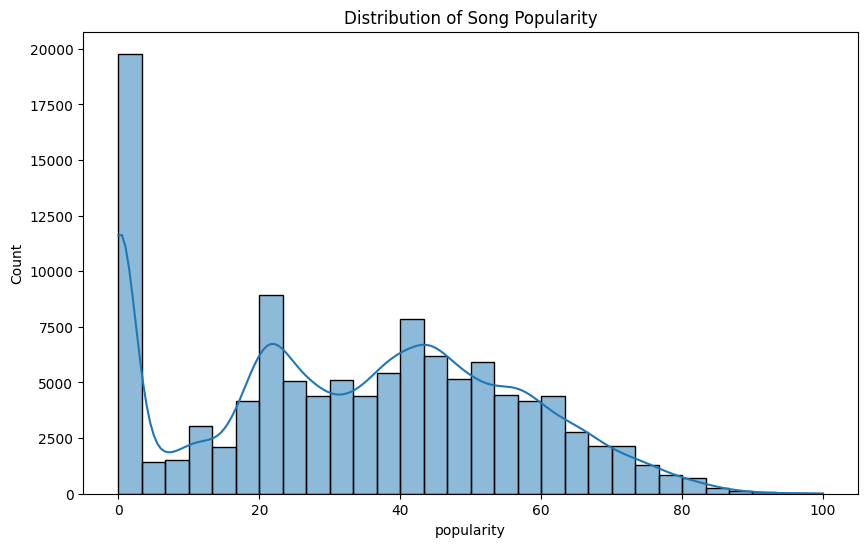

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Distribution of Song Popularity")
plt.show()

Remove Extremely Low-Popularity Songs

In [ ]:
df = df[df['popularity'] > 5]  # Remove songs with popularity <= 5

Apply Log Transformation to Normalize Popularity

In [ ]:
df['popularity_log'] = np.log1p(df['popularity'])

Replot Popularity

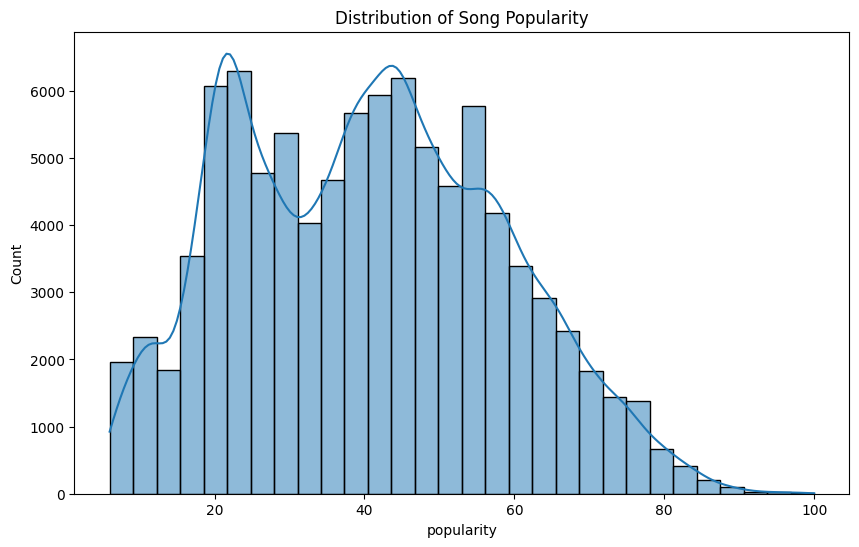

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Distribution of Song Popularity")
plt.show()

#**Define popularity subsets (labels)**

Classify songs with popularity score less than 50 as not popular, then apply hierarchical clustering to popular songs.*italicized text*

In [ ]:
# Define hit vs. non-hit classification
threshold = 50
df['hit'] = (df['popularity'] >= threshold).astype(int)

# Separate popular and non-popular songs
df_popular = df[df['hit'] == 1].copy()
df_non_popular = df[df['hit'] == 0].copy()

Apply Hierarchical Clustering only to songs with popularity 50 - 100

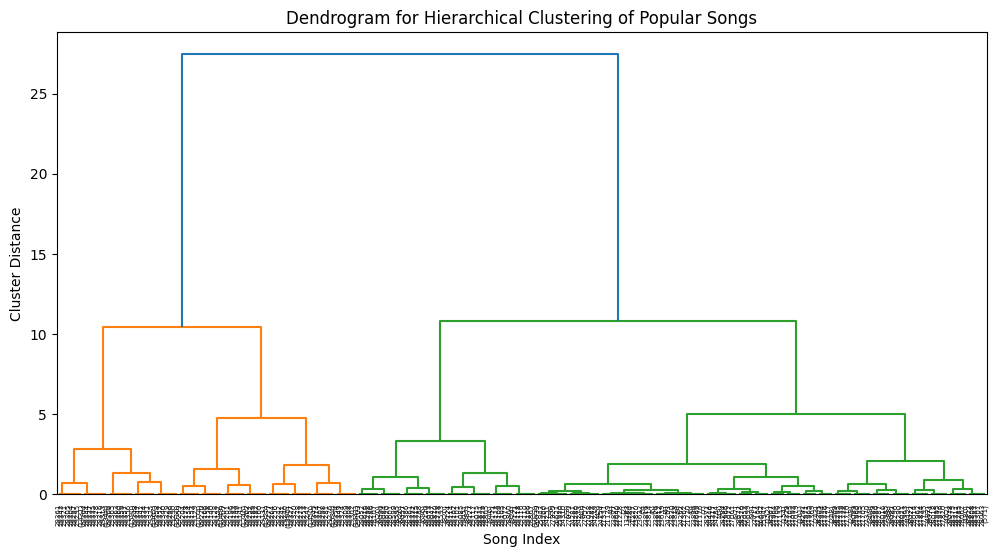

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linkage_matrix = linkage(df_popular[['popularity_log']], method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title("Dendrogram for Hierarchical Clustering of Popular Songs")
plt.xlabel("Song Index")
plt.ylabel("Cluster Distance")
plt.show()

Find >= 50 popularity clusters by cutting the dendrogram at an optimal distance

In [ ]:
optimal_clusters = fcluster(linkage_matrix, t=10, criterion='distance')
df_popular.loc[:, 'popularity_subcluster'] = optimal_clusters
print(df_popular['popularity_subcluster'].value_counts())

popularity_subcluster
2    10557
1     7375
3     6589
4     4846
Name: count, dtype: int64


In [ ]:
import pandas as pd
from scipy import stats

# Group by popularity_subcluster and calculate statistics
subcluster_stats = df_popular.groupby('popularity_subcluster')['popularity'].agg(
    Low='min',  # Lowest value in the subcluster
    High='max',  # Highest value in the subcluster
    Range=lambda x: x.max() - x.min(),
    Mean='mean',
    Mode=lambda x: stats.mode(x, keepdims=True)[0][0]
)

# Display the results
print("Popularity Subcluster Statistics:")
print(subcluster_stats)

Popularity Subcluster Statistics:
                       Low  High  Range       Mean  Mode
popularity_subcluster                                   
1                       50    54      4  51.934508    50
2                       55    62      7  58.231410    56
3                       63    70      7  66.111398    63
4                       71   100     29  76.654560    71


Visualize popularity subclusters

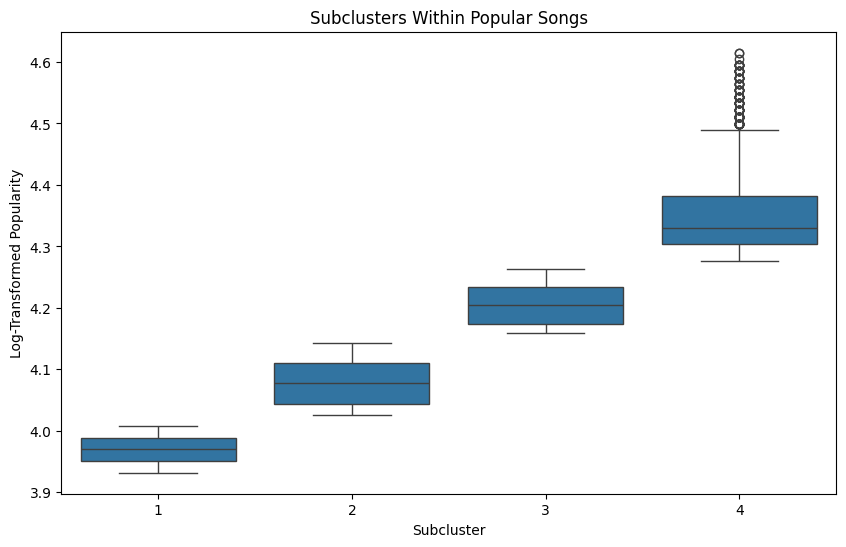

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_popular['popularity_subcluster'], y=df_popular['popularity_log'])
plt.title("Subclusters Within Popular Songs")
plt.xlabel("Subcluster")
plt.ylabel("Log-Transformed Popularity")
plt.show()

Assign labels to popularity subclusters

In [ ]:
def assign_label(x):
    subcluster_labels = {
        1: "Moderate Hit",
        2: "Strong Hit",
        3: "Super Hit",
        4: "Blockbuster Hit"
    }
    return f"{x} - " + subcluster_labels.get(x, "Hit")

df_popular = df_popular.copy()
df_non_popular = df_non_popular.copy()

df_popular.loc[:, 'popularity_subcluster_label'] = df_popular['popularity_subcluster'].apply(assign_label)
df_non_popular.loc[:, 'popularity_subcluster_label'] = "0 - Not Hit"

df_combined = pd.concat([df_popular, df_non_popular])

Analyze Feature Differences Across Subclusters

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_means = df_popular.groupby('popularity_subcluster_label')[['danceability', 'energy', 'tempo', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'key', 'mode', 'time_signature']].mean()
feature_means_scaled = pd.DataFrame(scaler.fit_transform(feature_means),
                                    index=feature_means.index,
                                    columns=feature_means.columns)
print("Feature Analysis Across Subclusters:")
print(feature_means)

# Analyze Feature Differences for Non-Popular Songs (<50 Popularity)
feature_means_non_popular = df_non_popular.groupby('popularity_subcluster_label')[['danceability', 'energy', 'tempo', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'key', 'mode', 'time_signature']].mean()
feature_means_non_popular_scaled = pd.DataFrame(scaler.transform(feature_means_non_popular),
                                    index=feature_means_non_popular.index,
                                    columns=feature_means_non_popular.columns)
print("Feature Analysis for Non-Popular Songs:")
print(feature_means_non_popular)

Feature Analysis Across Subclusters:
                             danceability    energy       tempo   valence  \
popularity_subcluster_label                                                 
1 - Moderate Hit                 0.563881  0.612809  122.935265  0.404477   
2 - Strong Hit                   0.572528  0.617720  121.409104  0.444235   
3 - Super Hit                    0.588731  0.639939  121.537113  0.482407   
4 - Blockbuster Hit              0.618636  0.674559  119.977705  0.505110   

                             speechiness  acousticness  instrumentalness  \
popularity_subcluster_label                                                
1 - Moderate Hit                0.072322      0.326992          0.172215   
2 - Strong Hit                  0.075829      0.318139          0.136998   
3 - Super Hit                   0.076925      0.283402          0.072334   
4 - Blockbuster Hit             0.075950      0.216604          0.035146   

                             liveness  loud

**Visualize Feature Differences for Both Popular and Non-Popular Songs**

Speechiness and Acousticness stand out as having significant variance for non-hit songs compared to popular songs. Danceability, Energy, and Valence increase as you move towards more successful hits. Instrumentalness and Liveness are lower for hits, possibly indicating more vocal-driven, engaging tracks. Loudness and Tempo are fairly consistent across hits but more variable for non-hits.

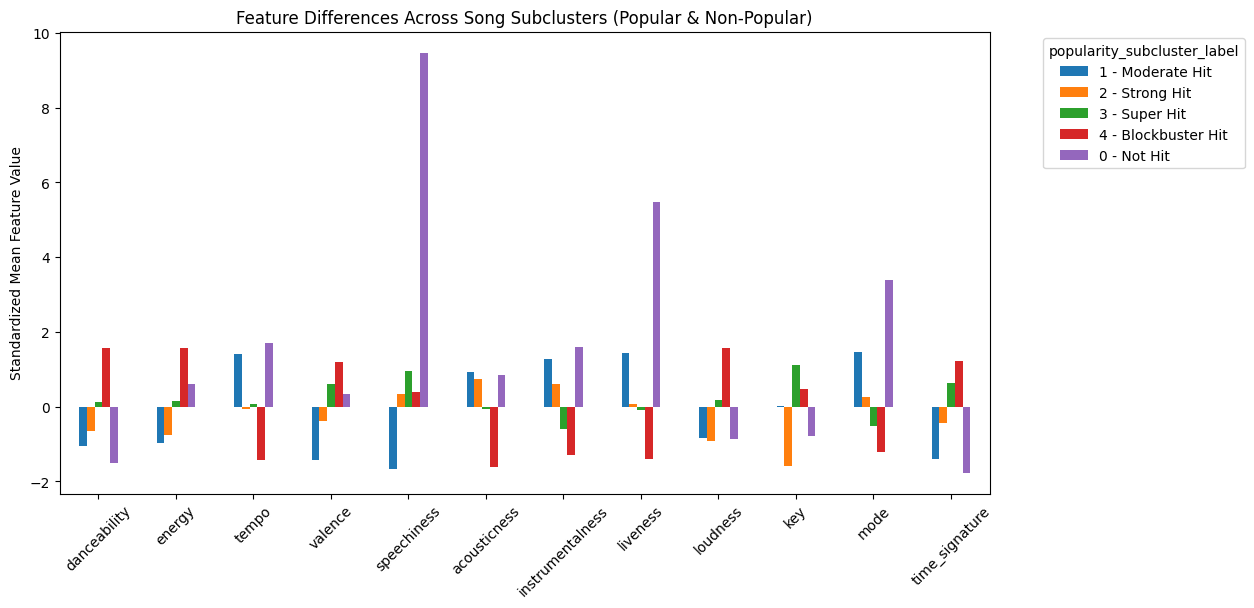

In [ ]:
#Merge both datasets for combined visualization
feature_means_combined = pd.concat([feature_means_scaled, feature_means_non_popular_scaled])

#Generate visualization
feature_means_combined.T.plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Feature Differences Across Song Subclusters (Popular & Non-Popular)")
plt.ylabel("Standardized Mean Feature Value")
plt.legend(title="popularity_subcluster_label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# **Feature Engineering**

Combine Popular and Non-Popular Data & Add Labels



In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
import numpy as np

# Combine popular and non-popular songs
df_combined = pd.concat([df_popular, df_non_popular])

# Check for NaN values in 'popularity_subcluster_label'
nan_count = df_combined['popularity_subcluster_label'].isna().sum()
print(f"NaN count in 'popularity_subcluster_label' before replacement: {nan_count}")

# Replace NaN values with "0 - Not Hit" (without using inplace)
df_combined['popularity_subcluster_label'] = df_combined['popularity_subcluster_label'].fillna("0 - Not Hit")

# Verify replacement
nan_count_after = df_combined['popularity_subcluster_label'].isna().sum()
print(f"NaN count in 'popularity_subcluster_label' after replacement: {nan_count_after}")

# Optionally, drop any remaining rows with NaN in this column (if any)
if nan_count_after > 0:
    df_combined = df_combined.dropna(subset=['popularity_subcluster_label'])
    print("Dropped rows with NaN in 'popularity_subcluster_label'.")

# Now encode the labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Ensure the column is treated as string
df_combined['popularity_subcluster_label'] = df_combined['popularity_subcluster_label'].astype(str)
df_combined['popularity_subcluster_label_encoded'] = label_encoder.fit_transform(df_combined['popularity_subcluster_label'])

# Verify that no NaN exists in the encoded labels
print("NaN count in 'popularity_subcluster_label_encoded':",
      df_combined['popularity_subcluster_label_encoded'].isna().sum())

NaN count in 'popularity_subcluster_label' before replacement: 0
NaN count in 'popularity_subcluster_label' after replacement: 0
NaN count in 'popularity_subcluster_label_encoded': 0


One-Hot Encode Categorical Features

In [ ]:
categorical_features = ['mode', 'key', 'time_signature']
df_encoded = pd.get_dummies(df_combined, columns=categorical_features, drop_first=True, dtype= int)

Scale Numerical Features

In [ ]:
scaler = StandardScaler()
numeric_features = ['danceability', 'energy', 'tempo', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'loudness']
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

#**Create Models with Musical Features**

In [ ]:
df_encoded.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_genre', 'popularity_log', 'hit',
       'popularity_subcluster', 'popularity_subcluster_label',
       'popularity_subcluster_label_encoded', 'mode_1', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')

In [ ]:
X = df_encoded.drop(columns=['popularity_subcluster_label', 'popularity_subcluster_label_encoded', 'popularity_subcluster',
                             'Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name','popularity','popularity_log','hit','track_genre'])
y = df_encoded['popularity_subcluster_label_encoded']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.columns

Index(['duration_ms', 'explicit', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'mode_1', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')

In [ ]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(kernel='rbf')
}

results = pd.DataFrame(columns=['Model', 'Accuracy'])

# Train and evaluate each model
for model_name, model in models.items():
    print(model_name, model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    results = pd.concat([results, pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy]
    })], ignore_index=True)
    print(classification_report(y_test, y_pred))

print(results)

RandomForest RandomForestClassifier()


<ipython-input-18-6cdbf5f1e2d4>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


              precision    recall  f1-score   support

           0       0.80      0.99      0.89     12773
           1       0.89      0.32      0.47      1475
           2       0.84      0.36      0.51      2112
           3       0.93      0.49      0.64      1318
           4       0.93      0.64      0.76       969

    accuracy                           0.81     18647
   macro avg       0.88      0.56      0.65     18647
weighted avg       0.83      0.81      0.79     18647

XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_d

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

              precision    recall  f1-score   support

           0       0.69      1.00      0.81     12773
           1       0.00      0.00      0.00      1475
           2       0.25      0.00      0.00      2112
           3       0.00      0.00      0.00      1318
           4       0.00      0.00      0.00       969

    accuracy                           0.68     18647
   macro avg       0.19      0.20      0.16     18647
weighted avg       0.50      0.68      0.56     18647

SVC SVC()
              precision    recall  f1-score   support

           0       0.68      1.00      0.81     12773
           1       0.00      0.00      0.00      1475
           2       0.00      0.00      0.00      2112
           3       0.00      0.00      0.00      1318
           4       0.00      0.00      0.00       969

    accuracy                           0.68     18647
   macro avg       0.14      0.20      0.16     18647
weighted avg       0.47      0.68      0.56     18647

            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Dimensionality Reduction with PCA

In [ ]:
# Determine optimal number of components for PCA
pca = PCA()
pca.fit(df_encoded[numeric_features])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_optimal = np.argmax(cumulative_variance >= 0.95) + 1  # Retain 95% variance
print(f"Optimal number of PCA components: {n_components_optimal}")

# Apply optimized PCA
pca = PCA(n_components=n_components_optimal)
pca_features = pca.fit_transform(df_encoded[numeric_features])
df_pca = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(n_components_optimal)])
df_encoded = pd.concat([df_encoded, df_pca], axis=1)

Optimal number of PCA components: 8


In [ ]:
X_train_pca,X_test_pca, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LogisticRegression': LogisticRegression()
    #'SVC': SVC(kernel='rbf')
}

results = pd.DataFrame(columns=['Model', 'Accuracy'])

# Train and evaluate each model
for model_name, model in models.items():
    print(model_name, model)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)

    results = pd.concat([results, pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy]
    })], ignore_index=True)

print(results)

RandomForest RandomForestClassifier()


<ipython-input-25-fd222650b177>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
LogisticRegression LogisticRegression()
                Model  Accuracy
0        RandomForest  0.812517
1             XGBoost  0.697753
2  LogisticRegression  0.684990


With just using musical features we are able to achieve an accuracy of 81.2%. These are encouraging results, and specifically we see that the random forest model performs the best. This is likely due to the large number of features and the complex, non-linear relationships they have with each other. We will now move forward with tuning the hyperparameters of the random forest model to get the best performance possible.

In [ ]:
#Hyperparameter tuning of the random forest model
param_grid = {
    'n_estimators': [700],
    'max_depth': [35]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 35, 'n_estimators': 700}
Best score: 0.7803550570658286
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     12773
           1       0.89      0.32      0.47      1475
           2       0.85      0.36      0.51      2112
           3       0.93      0.49      0.64      1318
           4       0.94      0.64      0.76       969

    accuracy                           0.81     18647
   macro avg       0.88      0.56      0.65     18647
weighted avg       0.83      0.81      0.79     18647

[[12678    30    43    14     8]
 [  963   465    34     7     6]
 [ 1304    19   763    20     6]
 [  601     8    41   651    17]
 [  320     2    18    11   618]]


[[12678    30    43    14     8]
 [  963   465    34     7     6]
 [ 1304    19   763    20     6]
 [  601     8    41   651    17]
 [  320     2    18    11   618]]


<Axes: >

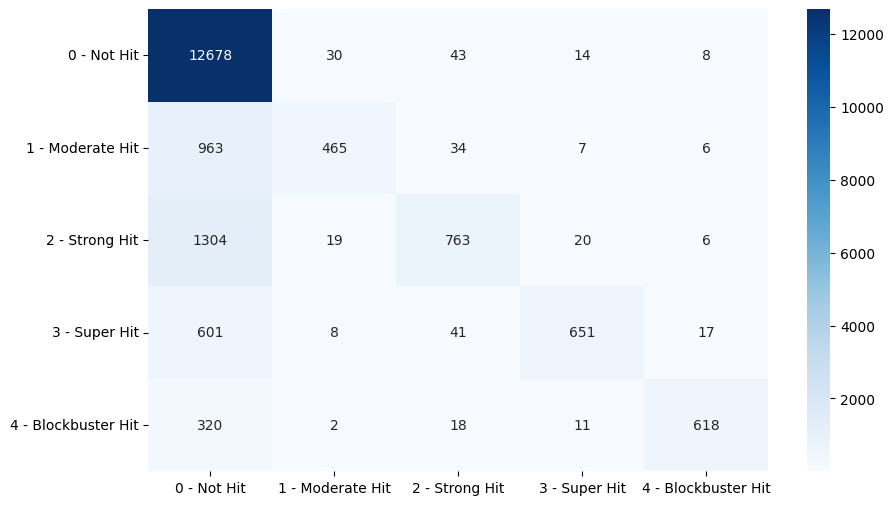

In [ ]:
#Create Confusion matrix for best_rf model
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

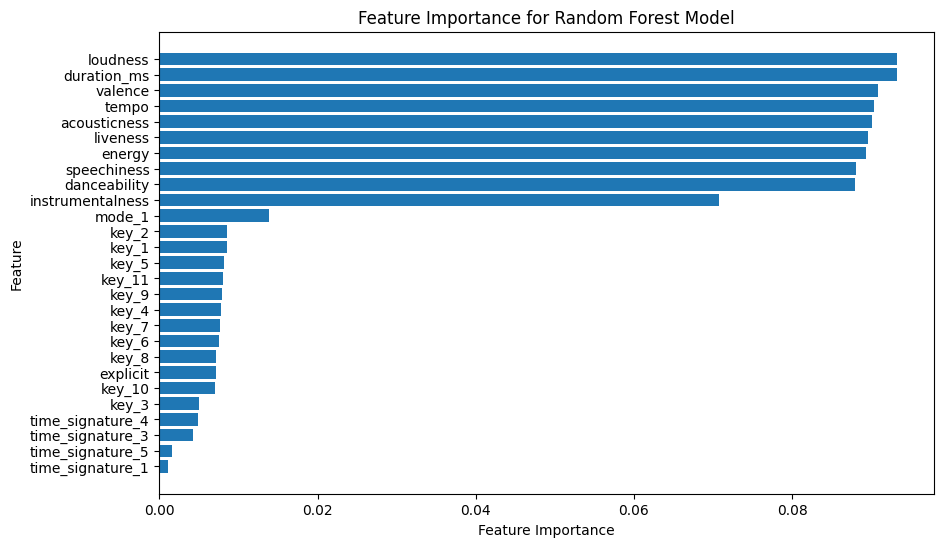

In [ ]:
#Get feature importance
feature_importance = best_rf.feature_importances_
feature_names = X_train.columns

#Sort by feature importance
sorted_idx = np.argsort(feature_importance)[::1]
feature_importance = feature_importance[sorted_idx]
feature_names = feature_names[sorted_idx]

#Graph it
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.show()

Check df_encoded columns

In [ ]:
print("Columns in df_encoded:", df_encoded.columns)

Columns in df_encoded: Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_genre', 'popularity_log', 'hit',
       'popularity_subcluster', 'popularity_subcluster_label',
       'popularity_subcluster_label_encoded', 'mode_1', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8'],
      dtype='object')


#**Create Artist-related Features**
Going for the hypothesis: better (more popular) artists = better (more popular) music

# **Artist EDA**

Summary of the number of tracks per artist:
count    29242.000000
mean         3.188257
std          7.372612
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        279.000000
Name: track_id, dtype: float64


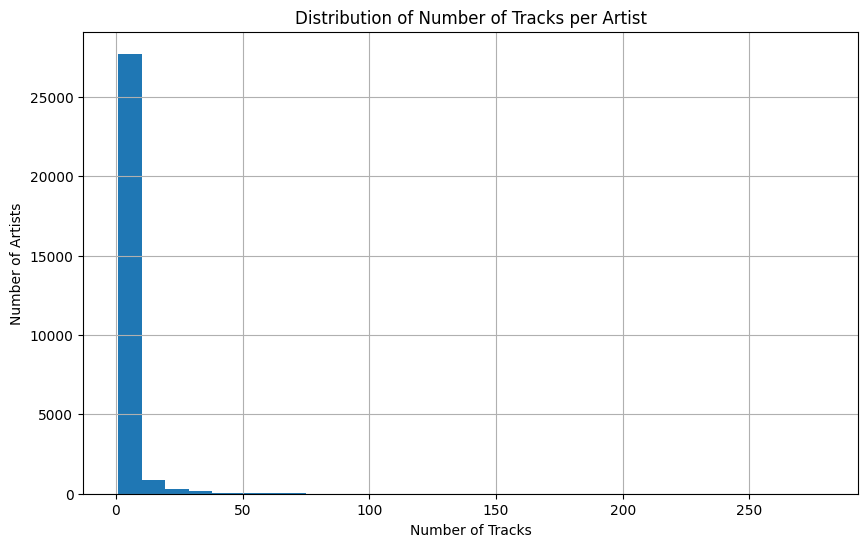

Top 10 artists by track count:
artists
The Beatles          279
George Jones         271
Linkin Park          224
Prateek Kuhad        217
Håkan Hellström      175
my little airport    171
Charlie Brown Jr.    169
Elvis Presley        166
Scooter              155
BTS                  151
Name: track_id, dtype: int64


In [ ]:
# Group by the 'artists' column and count how many tracks each artist has
artist_track_counts = df_encoded.groupby('artists')['track_id'].count()

# Print summary statistics (mean, median, min, max, etc.)
print("Summary of the number of tracks per artist:")
print(artist_track_counts.describe())

# Optionally, display a histogram of track counts per artist
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
artist_track_counts.hist(bins=30)
plt.title("Distribution of Number of Tracks per Artist")
plt.xlabel("Number of Tracks")
plt.ylabel("Number of Artists")
plt.show()

# See top 10 artists with the most tracks:
print("Top 10 artists by track count:")
print(artist_track_counts.sort_values(ascending=False).head(10))

**Single-track artists**

If there are a lot of these in each category, artist popularity may not be very important (i.e., people aren't looking for songs from their favorite artist)

Distribution of single-track artists by subcluster:
popularity_subcluster_label
0 - Not Hit            11555
1 - Moderate Hit        1327
2 - Strong Hit          2082
3 - Super Hit            909
4 - Blockbuster Hit      413
Name: track_id, dtype: int64


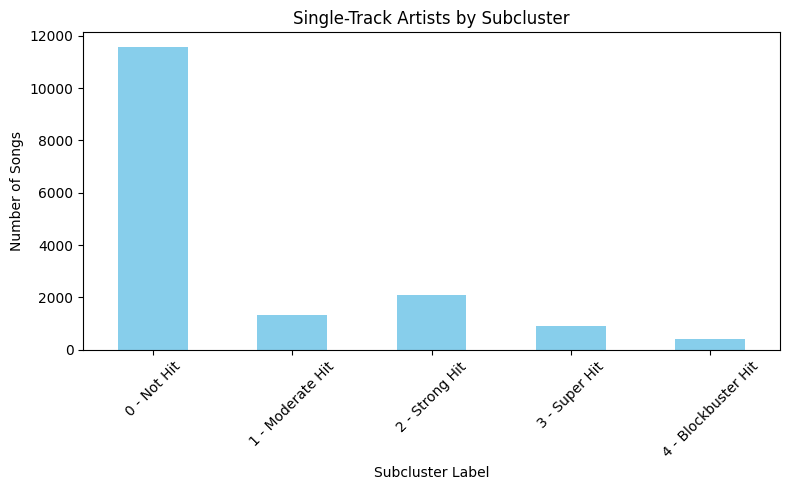

In [ ]:
# 1. Compute how many tracks each artist has
artist_track_counts = df_encoded.groupby('artists')['track_id'].count()

# 2. Identify artists with only 1 track
single_track_artists = artist_track_counts[artist_track_counts == 1].index

# 3. Filter df_combined to only rows where the artist is in single_track_artists
df_single_track = df_combined[df_combined['artists'].isin(single_track_artists)]

# 4. Group by subcluster (e.g., popularity_subcluster_label) and count the number of songs
distribution_by_subcluster = df_single_track.groupby('popularity_subcluster_label')['track_id'].count()
print("Distribution of single-track artists by subcluster:")
print(distribution_by_subcluster)

# 5. Optionally, visualize this distribution in a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
distribution_by_subcluster.plot(kind='bar', color='skyblue')
plt.title("Single-Track Artists by Subcluster")
plt.xlabel("Subcluster Label")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Multi-track Artists**

Popular artists = popular songs?

Distribution of multi-track artists by subcluster:
popularity_subcluster_label
0 - Not Hit            52309
1 - Moderate Hit        6048
2 - Strong Hit          8475
3 - Super Hit           5680
4 - Blockbuster Hit     4433
Name: track_id, dtype: int64


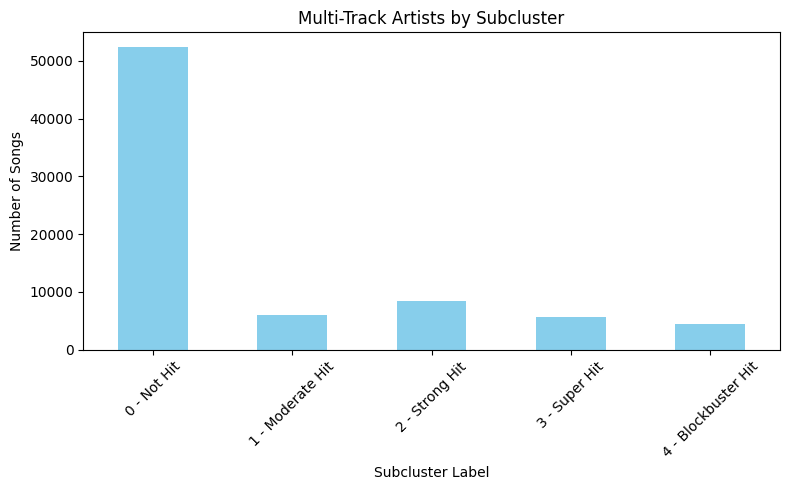

In [ ]:
# 1. Compute how many tracks each artist has
artist_track_counts = df_encoded.groupby('artists')['track_id'].count()

# 2. Identify artists with more than 1 track (multi-track artists)
multi_track_artists = artist_track_counts[artist_track_counts > 1].index

# 3. Filter df_combined to only rows where the artist is in multi_track_artists
df_multi_track = df_combined[df_combined['artists'].isin(multi_track_artists)]

# 4. Group by subcluster (e.g., popularity_subcluster_label) and count the number of songs
distribution_by_subcluster = df_multi_track.groupby('popularity_subcluster_label')['track_id'].count()
print("Distribution of multi-track artists by subcluster:")
print(distribution_by_subcluster)

# 5. Visualize this distribution in a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
distribution_by_subcluster.plot(kind='bar', color='skyblue')
plt.title("Multi-Track Artists by Subcluster")
plt.xlabel("Subcluster Label")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Create Artist-related Features**

Added **'artist_shrunk_pop'** as a proxy for artist popularity - *not to be conflated with track popularity*.

Took specific measures to reduce leakage in creating this popularity-related feature.

*   **Global Mean Calculation:** global_mean_pop is computed from all songs.
*   **Artist-Level Aggregation:** For each artist, we calculate the mean popularity, standard deviation, and the count of tracks.
*   **Shrinkage Calculation:** The formula combines the artist's mean popularity with the global mean, weighted by the number of songs (artist_song_count) and the hyperparameter alpha. For artists with only one song, the global mean has a larger influence, reducing leakage.

Added features to represent the artist's musical style

*   **'artist_mean_danceability'**
*   **'artist_mean_energy'**

Added feature to count how many tracks the artist has in dataset
*   **'artist_track_count'**

In [ ]:
# Compute global mean popularity
global_mean_pop = df_encoded['popularity'].mean()

# Set hyperparameter for shrinkage
alpha = 5

# Calculate artist-level statistics (only if 'artists' exists)
if 'artists' in df_encoded.columns:
    artist_stats = df_encoded.groupby('artists').agg({
        'popularity': ['mean', 'std', 'count'],
        'danceability': 'mean',  # you can add more audio features
        'energy': 'mean'
    }).reset_index()
    artist_stats.columns = ['artists', 'artist_mean_pop', 'artist_pop_std', 'artist_track_count',
                              'artist_mean_danceability', 'artist_mean_energy']

    # Compute shrunk artist popularity (combining artist mean with global mean)
    artist_stats['artist_shrunk_pop'] = (
        artist_stats['artist_track_count'] * artist_stats['artist_mean_pop'] + alpha * global_mean_pop
    ) / (artist_stats['artist_track_count'] + alpha)

    # Optionally, compute variance or other aggregations as needed.

    # Merge these features back into your main DataFrame (make sure to use the correct column name)
    df_encoded = df_encoded.merge(artist_stats[['artists','artist_shrunk_pop', 'artist_track_count',
                                                   'artist_mean_danceability', 'artist_mean_energy']],
                                    on='artists', how='left')
else:
    print("Warning: 'artists' column not found.")

Clean up columns, split train and test, validate train and test data format

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Drop any rows with NaN in the target, then reset index
df_encoded_clean = df_encoded.dropna(subset=['popularity_subcluster_label_encoded']).reset_index(drop=True)

# 2. Define X and y, removing columns that cause leakage or aren't needed
X = df_encoded_clean.drop(columns=[
    'artists',
    'Unnamed: 0',
    'popularity',
    'hit',
    'track_id',
    'album_name',
    #'popularity_cluster',
    'popularity_subcluster',
    'popularity_subcluster_label',
    'popularity_subcluster_label_encoded',  # target column
    'popularity_log',                       # derived from popularity
    #'popularity_log_scaled'                 # derived from popularity
])

y = df_encoded_clean['popularity_subcluster_label_encoded']

# Double-check for NaNs in X and y
print("NaN count in X:", X.isna().sum().sum())
print("NaN count in y:", y.isna().sum())
print("X shape:", X.shape)
print("y shape:", y.shape)

# 3. Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

########################################
# Clean up non-numeric columns in X_train / X_test
########################################

# Identify potential non-numeric columns
non_numeric_cols = [
    'track_name', 'track_genre', 'explicit',
    'mode_1', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
    'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
    'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'
]

# 1. Drop purely textual columns if they're not needed
drop_cols = ['track_name', 'track_genre']
for col in drop_cols:
    if col in X_train.columns:
        X_train.drop(columns=[col], inplace=True)
    if col in X_test.columns:
        X_test.drop(columns=[col], inplace=True)

# 2. Convert 'explicit' from True/False or string to int
if 'explicit' in X_train.columns:
    X_train['explicit'] = X_train['explicit'].map({True: 1, False: 0, 'True': 1, 'False': 0})
if 'explicit' in X_test.columns:
    X_test['explicit'] = X_test['explicit'].map({True: 1, False: 0, 'True': 1, 'False': 0})

# 3. Convert leftover one-hot columns (mode_1, key_1, etc.) to numeric
one_hot_cols = [
    'mode_1', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
    'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
    'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'
]
for col in one_hot_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(float)
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(float)

# Double-check no non-numeric columns remain in X_train or X_test
non_numeric_after_train = X_train.select_dtypes(exclude=[np.number]).columns
non_numeric_after_test = X_test.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns after fixes in X_train:", non_numeric_after_train)
print("Non-numeric columns after fixes in X_test:", non_numeric_after_test)

NaN count in X: 0
NaN count in y: 0
X shape: (93231, 33)
y shape: (93231,)
Non-numeric columns after fixes in X_train: Index([], dtype='object')
Non-numeric columns after fixes in X_test: Index([], dtype='object')


In [ ]:
print("Columns in X after dropping leakage columns:", X.columns)

Columns in X after dropping leakage columns: Index(['track_name', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_genre', 'mode_1', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'artist_shrunk_pop',
       'artist_track_count', 'artist_mean_danceability', 'artist_mean_energy'],
      dtype='object')


# **Run Models**

#**List of Models Tested**

1.   Random Forest with Permutation Importance
2.   Random Forest with Permutation Importance - Optimized Features for Blockbuster Hit Prediction
3.   Random Forest with GridSearchCV
4.   Random Forest with Lasso-selected Features
5.   XGBoost
7.   SVM

***Random Forest***
Random Forest (RF) is a strong model for predicting song popularity because it is robust, interpretable, and handles complex relationships well.

# **Random Forest with permutation importance**

In [ ]:
# Train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Now compute permutation importance on X_test
importances = permutation_importance(model, X_test, y_test, scoring='accuracy')

# Build a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importances.importances_mean
})

Sort by importance and display

In [ ]:
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print("Feature Importance (Permutation):")
print(feature_importance)

Feature Importance (Permutation):
                     feature  importance
27         artist_shrunk_pop    0.311235
28        artist_track_count    0.096058
7           instrumentalness    0.009192
8                   liveness    0.006039
0                duration_ms    0.004773
4                   loudness    0.004730
6               acousticness    0.004537
29  artist_mean_danceability    0.003883
3                     energy    0.003068
9                    valence    0.003068
30        artist_mean_energy    0.002113
2               danceability    0.001738
10                     tempo    0.001319
5                speechiness    0.000912
13                     key_2    0.000343
22                    key_11    0.000225
21                    key_10    0.000129
15                     key_4    0.000129
12                     key_1    0.000118
26          time_signature_5    0.000097
16                     key_5    0.000097
1                   explicit    0.000064
14                     

Select **Top 20** Features for Model

In [ ]:
selected_features = feature_importance['feature'].head(20).tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Train Multi-Class Model

In [ ]:
final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_train_selected, y_train)

y_pred = final_model.predict(X_test_selected)

Evaluate Multi-Class Model

                     precision    recall  f1-score   support

        0 - Not Hit       0.95      0.97      0.96     12773
   1 - Moderate Hit       0.81      0.57      0.67      1475
     2 - Strong Hit       0.72      0.78      0.75      2112
      3 - Super Hit       0.78      0.75      0.77      1318
4 - Blockbuster Hit       0.83      0.84      0.83       969

           accuracy                           0.90     18647
          macro avg       0.82      0.78      0.80     18647
       weighted avg       0.90      0.90      0.89     18647



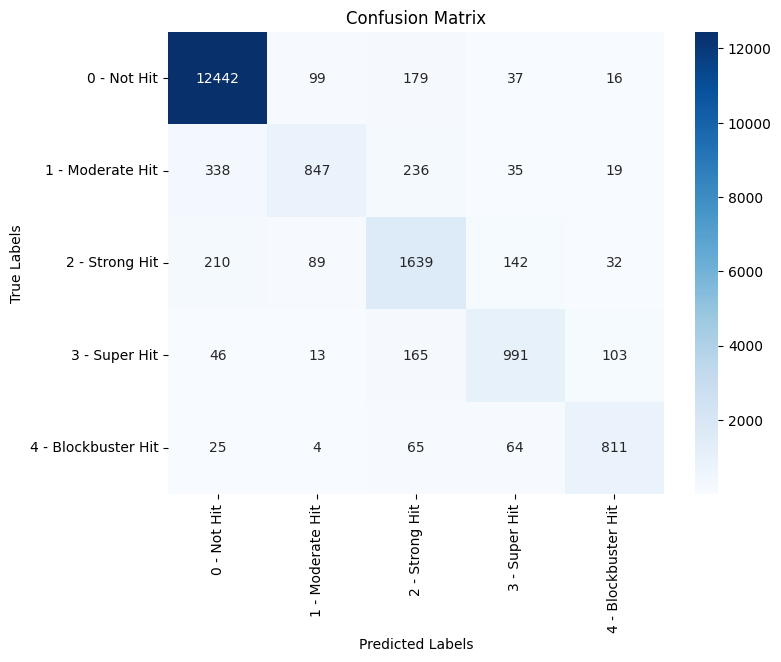

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Ensure labels match the encoded classes
labels = list(map(str, label_encoder.classes_))  # Convert class names to strings if needed

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

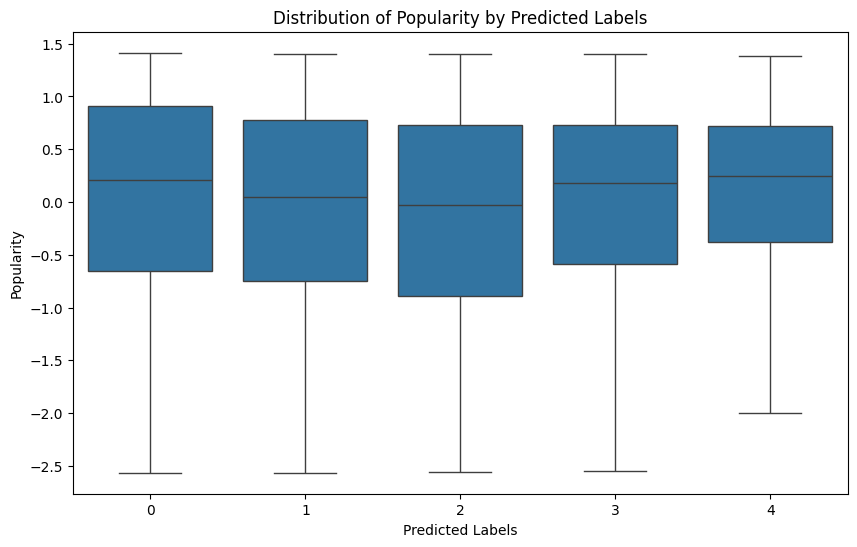

In [ ]:
visualization_df = pd.DataFrame({
    'True Labels': y_test,
    'Predicted Labels': y_pred
})

#Combine with X_test
visualization_df = pd.concat([visualization_df, X_test], axis=1)

#Plot distribution of popularity across predicted labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='Predicted Labels', y='energy', data=visualization_df, showfliers = False)
plt.title('Distribution of Popularity by Predicted Labels')
plt.xlabel('Predicted Labels')
plt.ylabel('Popularity')
plt.show()

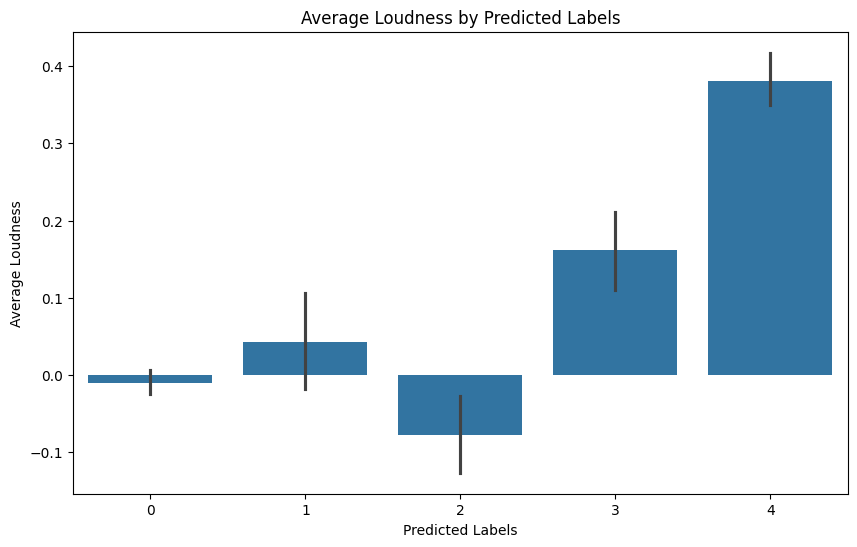

In [ ]:
#Plot average energy by predicted cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Predicted Labels', y='loudness', data=visualization_df)
plt.title('Average Loudness by Predicted Labels')
plt.xlabel('Predicted Labels')
plt.ylabel('Average Loudness')
plt.show()


# **Predicting Blockbuster Hits: Optimized Random Forest (with Permutation Importance)**

Training model with top 1 features...
Training model with top 2 features...
Training model with top 3 features...
Training model with top 4 features...
Training model with top 5 features...
Training model with top 6 features...
Training model with top 7 features...
Training model with top 8 features...
Training model with top 9 features...
Training model with top 10 features...
Training model with top 11 features...
Training model with top 12 features...
Training model with top 13 features...
Training model with top 14 features...
Training model with top 15 features...
Training model with top 16 features...
Training model with top 17 features...
Training model with top 18 features...
Training model with top 19 features...
Training model with top 20 features...
Training model with top 21 features...
Training model with top 22 features...
Training model with top 23 features...
Training model with top 24 features...
Training model with top 25 features...
Training model with top 26 feature

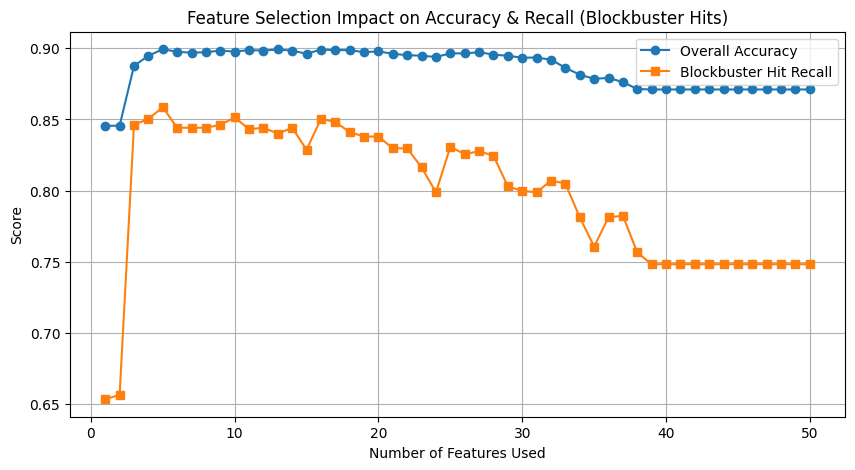

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define storage for results
feature_counts = list(range(1, 51))  # Testing top 1 to 50 features
accuracy_scores = []
recall_scores = []

blockbuster_hit_index = list(label_encoder.classes_).index("4 - Blockbuster Hit")  # Get index for 'Blockbuster Hit'

for num_features in feature_counts:
    print(f"Training model with top {num_features} features...")

    # Select top 'num_features' features
    selected_features = feature_importance['feature'].head(num_features).tolist()
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Train RandomForest model
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train_selected, y_train)

    # Predictions
    y_pred = model.predict(X_test_selected)

    # Overall Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Recall for Blockbuster Hit class
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_blockbuster = report[f"{blockbuster_hit_index}.0"]['recall']
    recall_scores.append(recall_blockbuster)

# Plot Accuracy & Recall vs. Number of Features
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, accuracy_scores, label="Overall Accuracy", marker='o')
plt.plot(feature_counts, recall_scores, label="Blockbuster Hit Recall", marker='s')

plt.xlabel("Number of Features Used")
plt.ylabel("Score")
plt.title("Feature Selection Impact on Accuracy & Recall (Blockbuster Hits)")
plt.legend()
plt.grid(True)
plt.show()

Optimal number of features for 'Blockbuster Hit' prediction accuracy and recall

Best Number of Features: 5
Features included in the best predictor count:
['artist_shrunk_pop', 'artist_track_count', 'loudness', 'instrumentalness', 'acousticness']


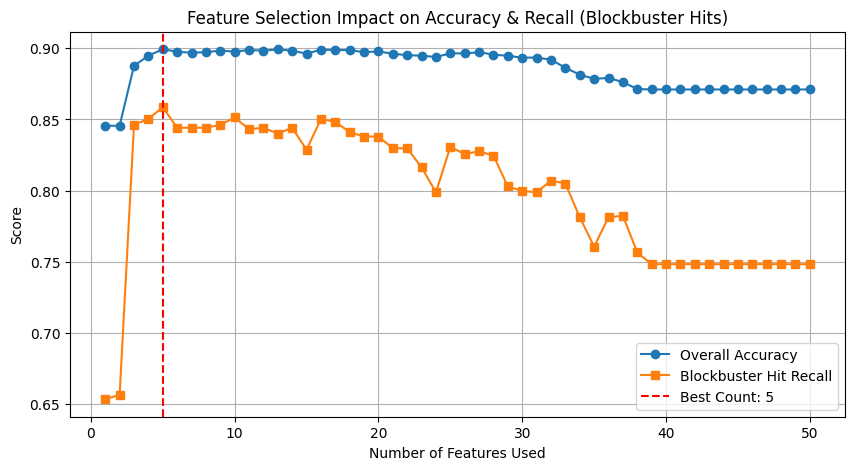

In [ ]:
# Find the best number of features based on the highest recall for Blockbuster Hits
best_feature_count = feature_counts[np.argmax(recall_scores)]

# Get the top features at the best predictor count
best_selected_features = feature_importance['feature'].head(best_feature_count).tolist()

print(f"Best Number of Features: {best_feature_count}")
print("Features included in the best predictor count:")
print(best_selected_features)

# Visualizing the best selection on the plot
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, accuracy_scores, label="Overall Accuracy", marker='o')
plt.plot(feature_counts, recall_scores, label="Blockbuster Hit Recall", marker='s')

# Mark the best feature count
plt.axvline(best_feature_count, color='red', linestyle='--', label=f"Best Count: {best_feature_count}")

plt.xlabel("Number of Features Used")
plt.ylabel("Score")
plt.title("Feature Selection Impact on Accuracy & Recall (Blockbuster Hits)")
plt.legend()
plt.grid(True)
plt.show()

**Best Number of Features: 5**

The red dashed vertical line at 5 features represents the optimal number of features that maximized recall for Blockbuster Hits.These features are:

*   artist_shrunk_pop (Shrinkage-adjusted popularity of the artist)
*   artist_track_count (Number of tracks the artist has in the dataset)
*   loudness (Overall volume of the track)
*   instrumentalness (Degree to which a track lacks vocals)
*   acousticness (Likelihood that a track is acoustic)

**Overall Accuracy (Blue Line)**

*   Accuracy increases sharply up to ~5 features, then plateaus around 90%.
*   After ~20 features, accuracy gradually declines, suggesting adding more features introduces noise.

**Blockbuster Hit Recall (Orange Line)**

*   Recall improves rapidly from ~65% to ~85% as features are added up to 5.
*   After 5 features, recall becomes unstable and gradually declines.
*   More features do not consistently improve recall; they likely introduce noise or overfitting.

Select **Top 5 (Optimized # of Features for Blockbusters)**, train model, and visualize results

                     precision    recall  f1-score   support

        0 - Not Hit       0.96      0.97      0.96     12773
   1 - Moderate Hit       0.75      0.61      0.67      1475
     2 - Strong Hit       0.75      0.76      0.76      2112
      3 - Super Hit       0.78      0.77      0.78      1318
4 - Blockbuster Hit       0.83      0.86      0.84       969

           accuracy                           0.90     18647
          macro avg       0.81      0.79      0.80     18647
       weighted avg       0.90      0.90      0.90     18647



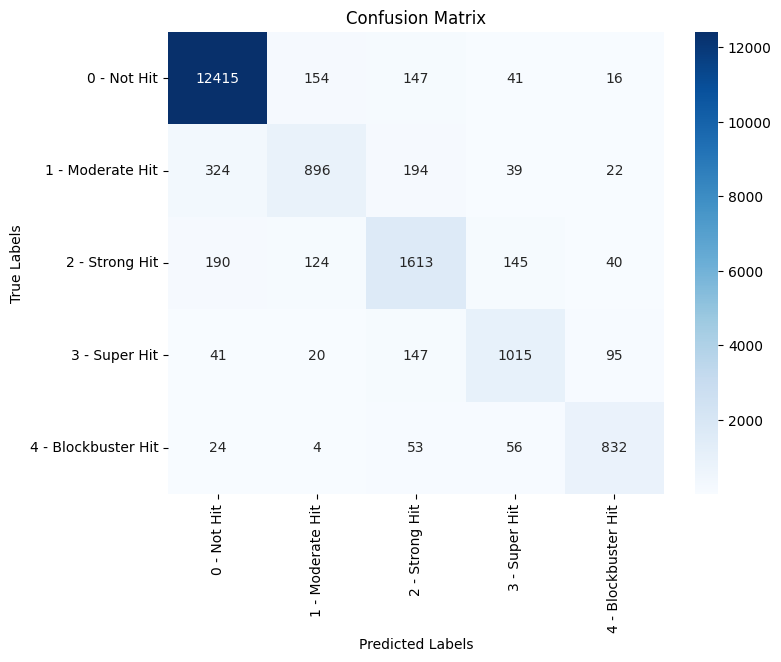

In [ ]:
#Select Top Features for Model
selected_features = feature_importance['feature'].head(5).tolist() #Selecting top 5
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

#Train Model
final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_train_selected, y_train)

y_pred = final_model.predict(X_test_selected)

#Visualize Results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Ensure labels match the encoded classes
labels = list(map(str, label_encoder.classes_))  # Convert class names to strings if needed

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Random Forest Optimization: GridSearchCV**

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Classification Report:
                     precision    recall  f1-score   support

        0 - Not Hit       0.95      0.97      0.96     12773
   1 - Moderate Hit       0.82      0.55      0.66      1475
     2 - Strong Hit       0.70      0.78      0.74      2112
      3 - Super Hit       0.78      0.73      0.76      1318
4 - Blockbuster Hit       0.81      0.81      0.81       969

           accuracy                           0.89     18647
          macro avg       0.81      0.77      0.79     18647
       weighted avg       0.89      0.89      0.89     18647



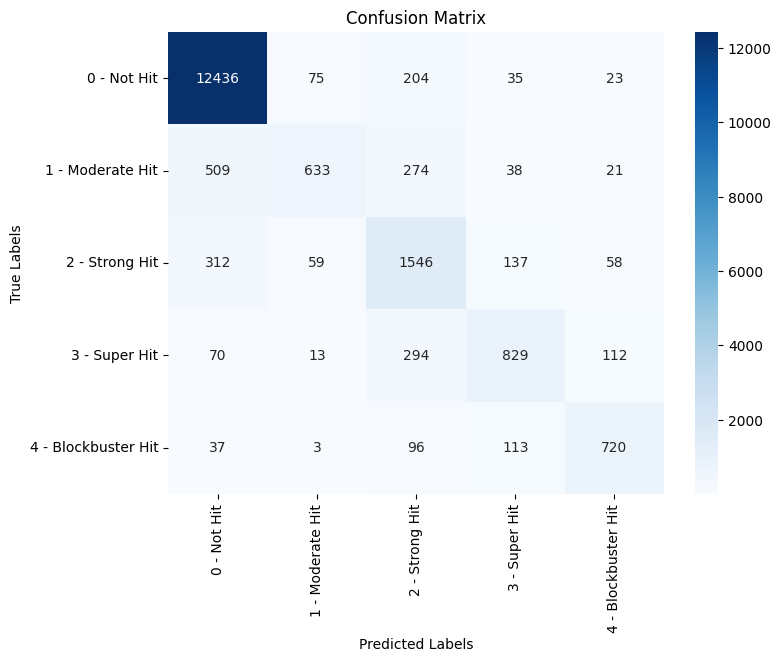

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with 3-fold cross-validation and macro F1 scoring
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=3,
                           n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Output the best parameters and best estimator
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_rf.predict(X_test_selected)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# Generate confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **Random Forest Optimization: Lasso-Based Feature Selection (using Logistic Regression with L1 penalty)**



Dropped rows with NaN. New shape: (60546, 39)
Lasso selected features: ['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_1', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'artist_shrunk_pop', 'artist_track_count', 'artist_mean_danceability', 'artist_mean_energy']

--- Running Random Forest with Lasso Selected Features ---
Lasso selected features: ['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_1', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC

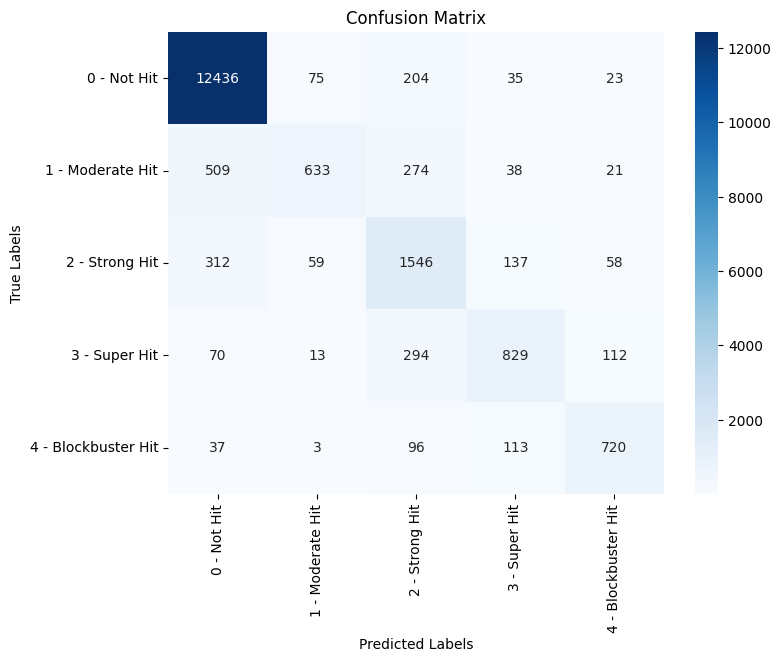

In [ ]:
# Make a copy to avoid mutating original data
X_train_lasso = X_train.copy()
y_train_lasso = y_train.copy()

# Drop rows in X_train_lasso that contain any NaNs
nan_mask = X_train_lasso.isna().any(axis=1)
X_train_lasso = X_train_lasso[~nan_mask]
y_train_lasso = y_train_lasso[~nan_mask]

print("Dropped rows with NaN. New shape:", X_train_lasso.shape)

# Now train LogisticRegression
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso.fit(X_train_lasso, y_train_lasso)

# SelectFromModel usage remains the same
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(lasso, prefit=True)
lasso_selected_features = X_train_lasso.columns[selector.get_support()].tolist()
print("Lasso selected features:", lasso_selected_features)

selected_features_dict = {
    "Lasso": lasso_selected_features,
}

from sklearn.metrics import classification_report, confusion_matrix

for method, features in selected_features_dict.items():
    print(f"\n--- Running Random Forest with {method} Selected Features ---")
    # Subset X_train and X_test to the selected features
    X_train_sel = X_train[features]
    X_test_sel = X_test[features]

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model.fit(X_train_sel, y_train)
    y_pred = rf_model.predict(X_test_sel)

    print(f"{method} selected features: {features}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Generate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#**XGBoost**

XGBoost (eXtreme Gradient Boosting) is an ensemble learning method that builds multiple weak learners (decision trees) sequentially to correct errors made by previous models. Predicting song popularity involves handling structured, numerical, and text data, which makes XGBoost a strong choice because:

- Handles Both Numerical & Categorical Data

- Captures Non-Linear Relationships (important for music features like tempo, loudness, etc.)

- Performs Well with High-Dimensional Data (PCA/SVD-reduced features)

- Good for Imbalanced Classification (since hits are rarer than non-hits)

- Robust Against Overfitting (via regularization techniques)

XGBoost Classification Report:
                     precision    recall  f1-score   support

        0 - Not Hit       0.93      0.97      0.95     12773
   1 - Moderate Hit       0.69      0.45      0.55      1475
     2 - Strong Hit       0.67      0.69      0.68      2112
      3 - Super Hit       0.69      0.64      0.66      1318
4 - Blockbuster Hit       0.77      0.75      0.76       969

           accuracy                           0.86     18647
          macro avg       0.75      0.70      0.72     18647
       weighted avg       0.86      0.86      0.86     18647



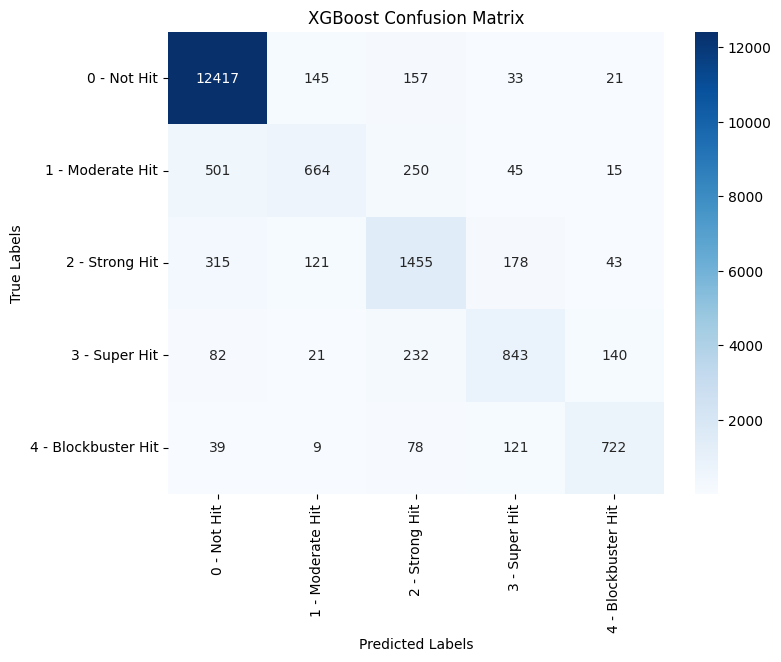

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train an XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# Compute and plot the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost Confusion Matrix')
plt.show()

# **SVM**

Support Vector Machines (SVM): could be a strong model for predicting song popularity due to its ability to handle high-dimensional data, non-linear relationships, and imbalanced datasets.

Specifically we may look at the RBP kernel for these kinds of patterns.

# **SVM Analysis of Results**

The confusion matrix shows a very problematic SVM model, where the model always predicts the same class (0 - Not Hit) for every input, regardless of its true label. This phenomenon is known as the “All-Negative” Problem or a “Single Class Prediction” problem.

Class Imbalance: Very high number of samples in the “0 - Not Hit” category (12,773) compared to the other categories (1,475 to 969). The model is biased toward the majority class and will predict that class for everything because it minimizes the overall error by doing so.

**Overall takeaway - will not use SVM for this since Random Forest results are acceptable.**

Selected features based on Mutual Information:
['artist_shrunk_pop', 'artist_mean_energy', 'artist_mean_danceability', 'duration_ms', 'tempo', 'loudness', 'instrumentalness', 'acousticness', 'artist_track_count', 'valence']
SVM Classification Report:
                     precision    recall  f1-score   support

        0 - Not Hit       0.68      1.00      0.81     12773
   1 - Moderate Hit       0.00      0.00      0.00      1475
     2 - Strong Hit       0.00      0.00      0.00      2112
      3 - Super Hit       0.00      0.00      0.00      1318
4 - Blockbuster Hit       0.00      0.00      0.00       969

           accuracy                           0.68     18647
          macro avg       0.14      0.20      0.16     18647
       weighted avg       0.47      0.68      0.56     18647



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


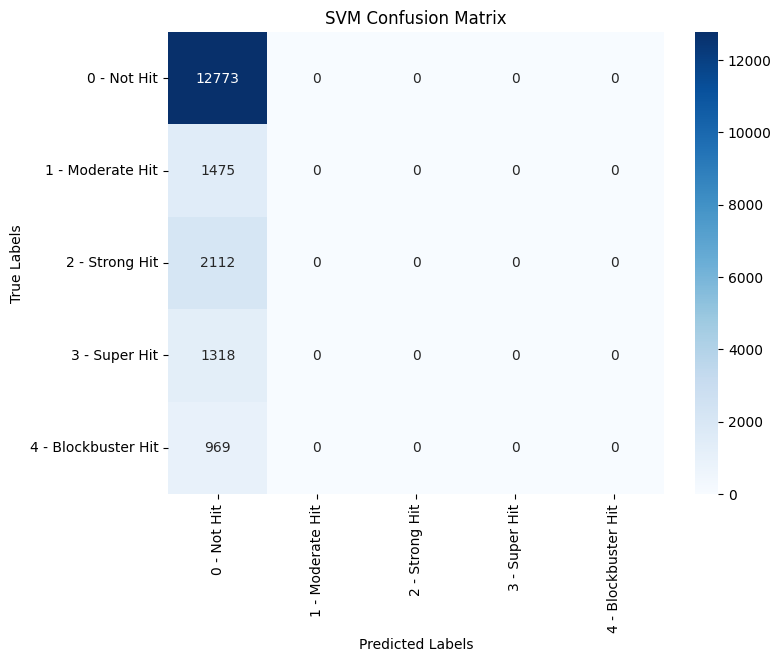

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Step 1: Handle Missing Values (Impute NaNs)
# -------------------------------
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column mean
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Ensure y_train has no NaNs
y_train = y_train.dropna()

# -------------------------------
# Step 2: Feature Selection using Mutual Information
# -------------------------------
mi_scores = mutual_info_classif(X_train_imputed, y_train, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X_train_imputed.columns)

# Sort and select the top 10 features
selected_features = mi_scores_series.sort_values(ascending=False).head(10).index.tolist()
print("Selected features based on Mutual Information:")
print(selected_features)

# Reduce training and testing sets to these features
X_train_selected = X_train_imputed[selected_features]
X_test_selected = X_test_imputed[selected_features]

# -------------------------------
# Step 3: Train the SVM Model
# -------------------------------
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_selected)

# -------------------------------
# Step 4: Evaluate Performance
# -------------------------------
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# -------------------------------
# Step 5: Compute & Visualize Confusion Matrix
# -------------------------------
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Confusion Matrix')
plt.show()